# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [48]:
from __future__ import print_function

In [49]:
from IPython.display import Image

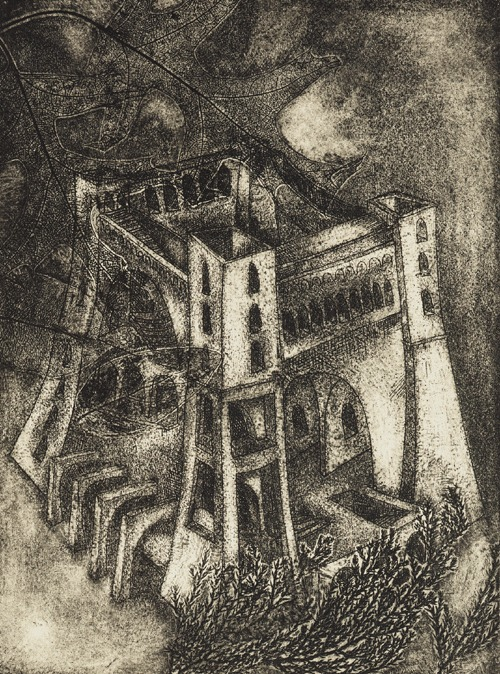

In [50]:
Image(filename='../../Images/zaira.jpg') 

### ZAIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)

        2. Simulates the response of the TRACKING plane (add gaussian and dark current noise), and produces SiPM RWF and store in output h5 file.
            
        3. Produces the SiPM calibration parameters

        4. Monitor the input SiPM MCRD and output SiPM RFW. 
        
author: Jose A. Hernando
version: v0_00 

### Revision

In [51]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

17/10/2016   11:46:55


### Dependencies

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
import tables
import pandas as pd
import time
import cProfile

In [54]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [55]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [56]:
pp = %env PYTHONPATH
print(pp)
from Util import *
from Configure import *
from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### Inspecting the input file  

In [256]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEWMC/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [301]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


In [270]:
# input histograms
def index_of_sensorid(sensorID):
    iboard = sensorID/1000
    isensor = sensorID%1000
    index = (iboard-1)*64+isensor
    return index

def sensorid_of_index(index):
    iboard = int(index/64)
    isensor = index%64
    senid = 1000*(iboard+1)+isensor
    return senid
    
nsipms = 28*64

class Caldata:
    
    def __init__(self,ifilename,nsensors=nsipms):
        data = np.loadtxt(ifilename)
        self.xbins = data[0,1:]
        self.nbins = len(self.xbins)
        self.senids = map(int,data[1:,0])
        self.indexes = []
        self.values = np.array([[0]*self.nbins,]*nsensors)
        for i,senid in enumerate(self.senids):
            index = index_of_sensorid(senid)
            self.indexes.append(index)
            print('sensor ID {} index {} i {}'.format(senid,index,i))
            self.values[index] = data[i+1,1:]
        return

In [274]:
senid0=2063
id = index_of_sensorid(senid0)
senid = sensorid_of_index(id)
print(' senid {} id {} senid {}'.format(senid0,id,senid))

 senid 2063 id 127 senid 2063


In [275]:
indir = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/'
infile = 'sipmCal_singlePulse_R2113'
called = Caldata(indir+infile+'_led.txt')
caldark = Caldata(indir+infile+'_dark.txt')

sensor ID 26008 index 1608 i 0
sensor ID 2002 index 66 i 1
sensor ID 25004 index 1540 i 2
sensor ID 12011 index 715 i 3
sensor ID 10034 index 610 i 4
sensor ID 20017 index 1233 i 5
sensor ID 2014 index 78 i 6
sensor ID 22063 index 1407 i 7
sensor ID 28051 index 1779 i 8
sensor ID 22027 index 1371 i 9
sensor ID 19031 index 1183 i 10
sensor ID 7027 index 411 i 11
sensor ID 6007 index 327 i 12
sensor ID 18003 index 1091 i 13
sensor ID 27061 index 1725 i 14
sensor ID 26051 index 1651 i 15
sensor ID 28054 index 1782 i 16
sensor ID 16019 index 979 i 17
sensor ID 13004 index 772 i 18
sensor ID 13043 index 811 i 19
sensor ID 7030 index 414 i 20
sensor ID 14028 index 860 i 21
sensor ID 25012 index 1548 i 22
sensor ID 6032 index 352 i 23
sensor ID 14016 index 848 i 24
sensor ID 11034 index 674 i 25
sensor ID 28039 index 1767 i 26
sensor ID 27012 index 1676 i 27
sensor ID 7053 index 437 i 28
sensor ID 14018 index 850 i 29
sensor ID 21049 index 1329 i 30
sensor ID 14009 index 841 i 31
sensor ID 24

In [276]:
def index_of_xrange(xs,x0,x1):
    i0,i1 = np.where(xs>=x0)[0][0],np.where(xs>=x1)[0][0]
    return i0,i1

def polo_cal(cal,indexes,x0=None,x1=None,figsize=None):
    n = len(indexes)
    nx = int(sqrt(n))
    ny = nx
    while (nx*ny<n):nx+=1
    if (not figsize): figsize=(4*ny,3*nx)
    plt.subplots(nx,ny,figsize=figsize)
    xs = cal.xbins
    if (not x0): x0 = np.min(xs)
    if (not x1): x1 = np.max(xs)
    i0,i1 = index_of_xrange(xs,x0,x1)
    for i,id in enumerate(indexes):
        plt.subplot(nx,ny,i+1)
        plt.plot(xs[i0:i1],cal.values[id,i0:i1])
        plt.yscale('log')
    plt.show()
    
def polo_cal2(cal1,cal2,indexes,x0=None,x1=None,figsize=None):
    n = len(indexes)
    nx = int(sqrt(n))
    ny = nx
    while (nx*ny<n):nx+=1
    if (not figsize): figsize=(4*ny,3*nx)
    plt.subplots(nx,ny,figsize=figsize)
    xs = cal1.xbins
    if (not x0): x0=np.min(xs)
    if (not x1): x1=np.max(xs)
    i0,i1 = index_of_xrange(xs,x0,x1)
    for i,id in enumerate(indexes):
        plt.subplot(nx,ny,i+1)
        plt.plot(xs[i0:i1],cal1.values[i,i0:i1])
        plt.plot(xs[i0:i1],cal2.values[i,i0:i1])
        plt.yscale('log')
    plt.show()

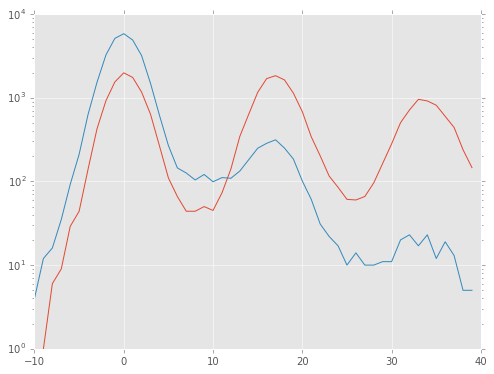

In [277]:
polo_cal2(called,caldark,range(1),-10.,40.,figsize=(8,6))

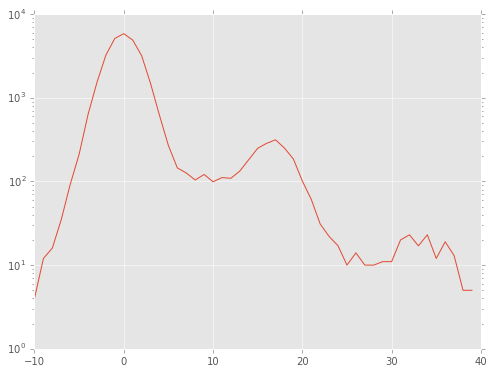

In [278]:
polo_cal(caldark,range(1),x0=-10.,x1=40.,figsize=(8,6))

In [279]:
from scipy.optimize import minimize_scalar
def fun_period(xs,ys):
    nbins = len(xs)
    def fun(pe):
        # set the bins to the corresponding int period
        x0s = np.array(map(int,xs/pe+0.5))*pe 
        # first bin non zero
        bin0 = np.where(x0s>0)[0][0] 
        # remove the zero and negative periods, keep only the positive ones
        x0s,x1s,y1s = x0s[bin0:],xs[bin0:],ys[bin0:]
        # compute the chi2
        chi2 = sqrt(np.sum((x0s-x1s)*(x0s-x1s)*y1s)/np.sum(y1s))
        return chi2
    return fun

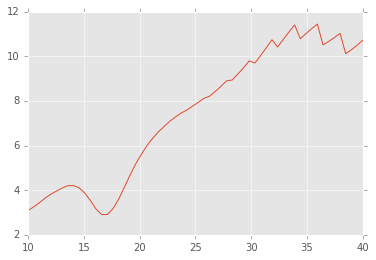

In [280]:
xs = called.xbins
ys = called.values[0]
fun = fun_period(xs,ys)
pes = np.linspace(10.,40.,60)
vals = np.array(map(lambda pe: fun(pe),pes))
plt.plot(pes,vals)

In [281]:
result = minimize_scalar(fun,bounds=[10,30.],method='Bounded')
print(result)

     fun: 2.872148960902094
 message: 'Solution found.'
    nfev: 17
  status: 0
 success: True
       x: 16.877363536822028


In [323]:
def cal_period(cal,indexes):
    def fit_(index):
        if (index%400==0): print('fiting...',index)
        fun = fun_period(cal.xbins,cal.values[index]) 
        result = minimize_scalar(fun,bounds=[12.,30.],method='Bounded')
        return result
    results = map(fit_, indexes)
    return results

In [324]:
indexes = called.indexes
res = cal_period(called,indexes)

fiting... 800
fiting... 400
fiting... 1600
fiting... 0
fiting... 1200


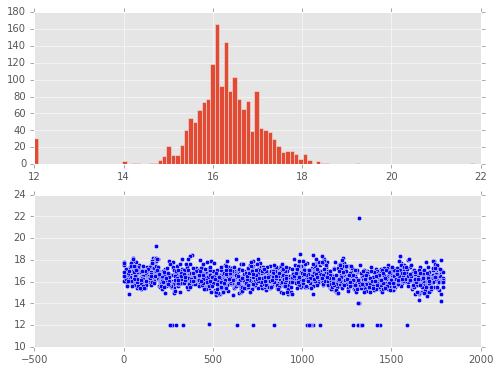

In [325]:
val = map(lambda x: x.x,res)
plt.subplots(2,1,figsize=(8,6))
plt.subplot(2,1,1)
c = plt.hist(val,100)
plt.subplot(2,1,2)
plt.scatter(indexes,val)

In [326]:
indexes = caldark.indexes
res = cal_period(caldark,indexes)

fiting... 400
fiting... 1200
fiting... 800
fiting... 1600
fiting... 0


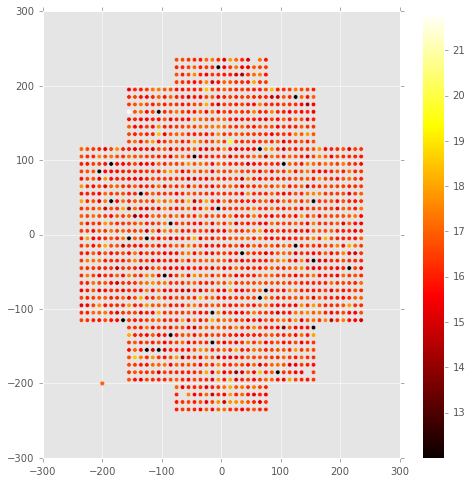

In [350]:
#map the position
senids = map(sensorid_of_index,indexes)
pos = map(sipm_position_of_sensorid,senids)
cxs = map(lambda x: x[0],pos)
cys = map(lambda x: x[1],pos)
plt.subplots(1,1,figsize=(8,8))
plt.scatter(cxs,cys,c=val,cmap='hot')
plt.colorbar()
plt.show()

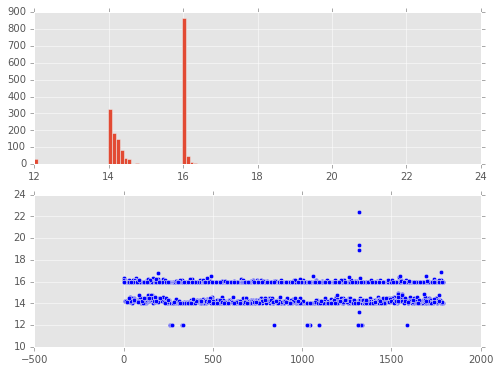

In [327]:
val2 = map(lambda x: x.x,res)
plt.subplots(2,1,figsize=(8,6))
plt.subplot(2,1,1)
c = plt.hist(val2,100)
plt.subplot(2,1,2)
plt.scatter(indexes,val2)

In [285]:
def cal_signal(xs,ydark,yled,period=1.):
    #print(' led {} dark {} '.format(np.sum(yled),np.sum(ydark)))
    ibin0 = np.where(xs>=0.)[0][0]
    frat = 1.*np.sum(yled[:ibin0])/(1.*np.sum(ydark[:ibin0]))
    #print(' f rat ',frat)
    ydark2 = frat*ydark
    sig = (yled-ydark2)/period
    return sig

def cal_muhat(sig,yled):
    fvis = (1.*sum(sig))/(1.*sum(yled))
    if (fvis>=1.): return -1.
    muhat = -1.*(log(1.-fvis))
    return muhat

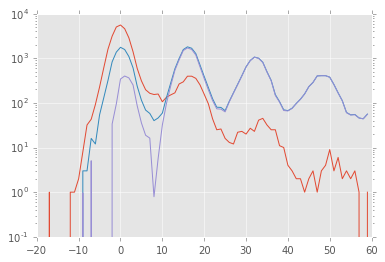

In [286]:
index = 10
xs,ydark,yled = caldark.xbins,caldark.values[index],called.values[1]
sig = cal_signal(xs,ydark,yled)
i0,i1 = index_of_xrange(xs,-20.,60.)
plt.plot(xs[i0:i1],ydark[i0:i1])
plt.plot(xs[i0:i1],yled[i0:i1])
plt.plot(xs[i0:i1],sig[i0:i1])
plt.yscale('log')
plt.show()

In [287]:
muhat = cal_muhat(sig,yled)
print(muhat)

1.36796318672


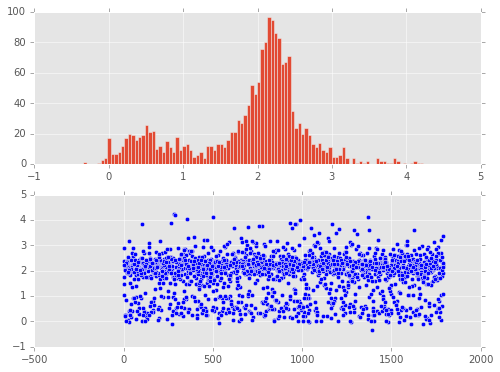

In [313]:
indexes = called.indexes
sigs = map(lambda i: cal_signal(caldark.xbins,caldark.values[i],called.values[i]),indexes)
muhats = map(lambda i: cal_muhat(sigs[i],called.values[i]),indexes)
plt.subplots(2,1,figsize=(8,6))
plt.subplot(2,1,1)
c= plt.hist(muhats,100)
plt.subplot(2,1,2)
#zz = zip(indexes,muhats)
plt.scatter(indexes,muhats)

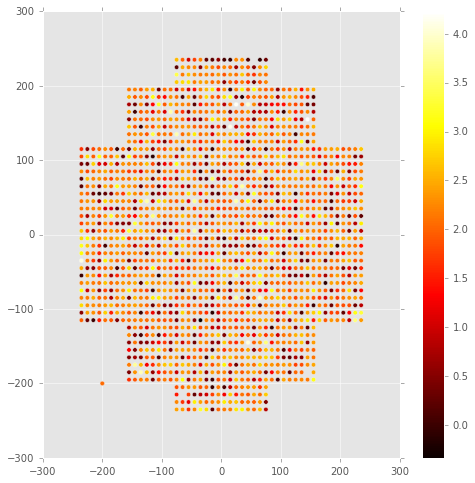

In [349]:
#map the position
senids = map(sensorid_of_index,indexes)
pos = map(sipm_position_of_sensorid,senids)
cxs = map(lambda x: x[0],pos)
cys = map(lambda x: x[1],pos)
plt.subplots(1,1,figsize=(8,8))
plt.scatter(cxs,cys,c=np.array(muhats),cmap='hot')
plt.colorbar()
plt.show()

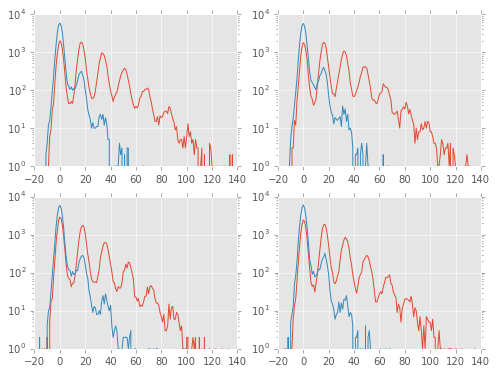

In [337]:
zz = zip(called.indexes,muhats)
zz0 = filter(lambda z: z[1]<1.,zz)
indexes0 = map(lambda z:z[0],zz0)
polo_cal2(called,caldark,indexes0[:4],x0=-20,x1=140.)

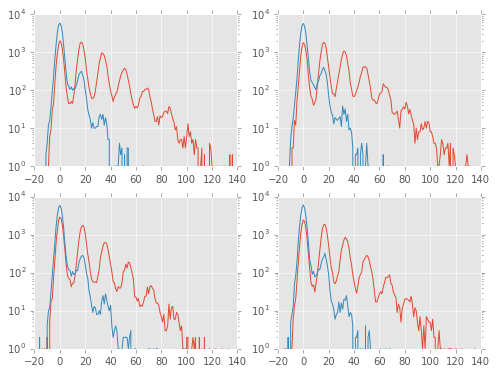

In [338]:
zz = zip(called.indexes,muhats)
zz2 = filter(lambda z: z[1]>1.8,zz)
indexes2 = map(lambda z:z[0],zz2)
polo_cal2(called,caldark,indexes2[:4],x0=-20,x1=140.)

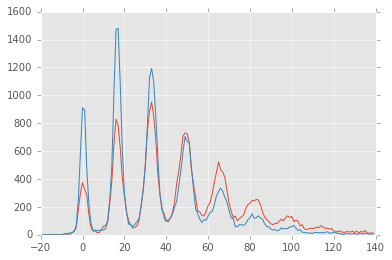

In [341]:
y0 = called.values[indexes0[0]]
y1 = called.values[indexes2[0]]
xs = called.xbins
i0,i1 = index_of_xrange(xs,-20.,140.)
plt.plot(xs[i0:i1],y0[i0:i1])
plt.plot(xs[i0:i1],y1[i0:i1])

In [343]:
fout = open(infile+'cal.txt','w')
fout.write(infile+'\n')
fout.write(str(called.indexes)+'\n')
fout.write(str(val)+'\n')
fout.write(str(muhats)+'\n')
fout.close()

That's all folks!